In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

In [2]:
fear_greed_Dataset = pd.read_csv(r"/content/fear_greed_index.csv")
historical_Dataset = pd.read_csv(r"/content/historical_data.csv")

In [3]:
fear_greed_Dataset['date'] = pd.to_datetime(fear_greed_Dataset['date'])
historical_Dataset['Timestamp IST'] = pd.to_datetime(historical_Dataset['Timestamp IST'], format="%d-%m-%Y %H:%M")
historical_Dataset['date'] = historical_Dataset['Timestamp IST'].dt.date
historical_Dataset['date'] = pd.to_datetime(historical_Dataset['date'])

In [4]:
merged_dataset = pd.merge(historical_Dataset, fear_greed_Dataset, on="date", how="left")

In [5]:
classification_order = {'Extreme Greed': 2, 'Extreme Fear': -2, 'Fear': -1, 'Greed': 1, 'Neutral': 0}
merged_dataset["classification"] = merged_dataset["classification"].map(classification_order)
merged_dataset["classification"] = merged_dataset["classification"].fillna(merged_dataset["classification"].mode()[0]).astype(int)
merged_dataset["value"] = merged_dataset["value"].fillna(merged_dataset["value"].median())

merged_dataset['Side'] = merged_dataset['Side'].map({'BUY': 1, 'SELL': 0}).astype(int)
merged_dataset.drop(columns=["Account", "Timestamp IST", "Transaction Hash", "Order ID",
                             "Trade ID", "Timestamp", "timestamp", "Crossed"], inplace=True, errors='ignore')
merged_dataset = merged_dataset.drop_duplicates()

In [6]:
numeric_cols = merged_dataset.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(merged_dataset[numeric_cols]))
merged_dataset_no_outliers = merged_dataset[(z_scores < 3).all(axis=1)]

In [7]:
merged_dataset["price_change"] = merged_dataset["Execution Price"].pct_change().fillna(0)
merged_dataset["rolling_mean_3"] = merged_dataset["Execution Price"].rolling(window=3).mean().fillna(method='bfill')
merged_dataset["pnl_per_token"] = merged_dataset["Closed PnL"] / (merged_dataset["Size Tokens"] + 1e-6)
merged_dataset["sentiment_side"] = merged_dataset["classification"] * merged_dataset["Side"]

In [8]:
merged_dataset["next_price"] = merged_dataset["Execution Price"].shift(-1)
merged_dataset["market_trend"] = (merged_dataset["next_price"] > merged_dataset["Execution Price"]).astype(int)
merged_dataset.dropna(subset=["market_trend"], inplace=True)

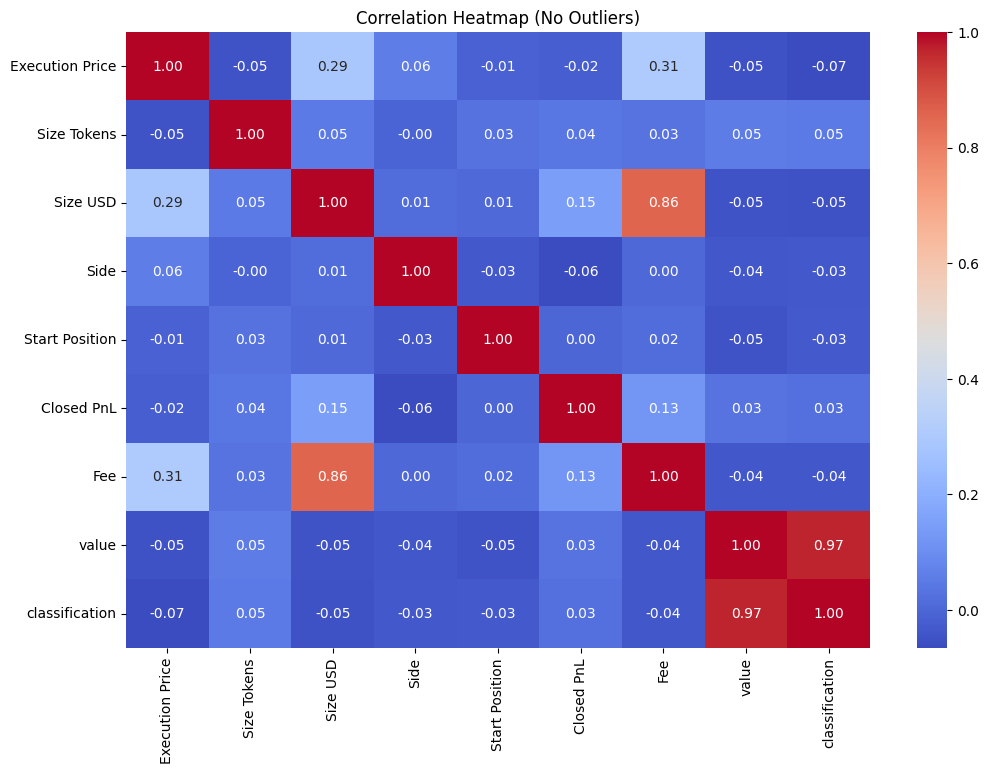

In [9]:
numerical_df=merged_dataset_no_outliers.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (No Outliers)")
plt.show()

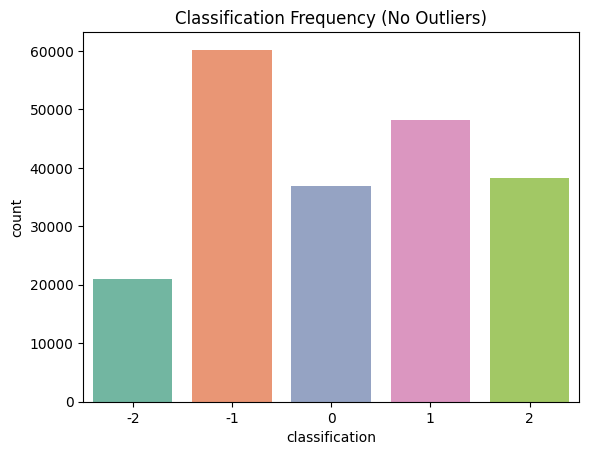

In [10]:
sns.countplot(x="classification", data=merged_dataset_no_outliers, palette="Set2")
plt.title("Classification Frequency (No Outliers)")
plt.show()

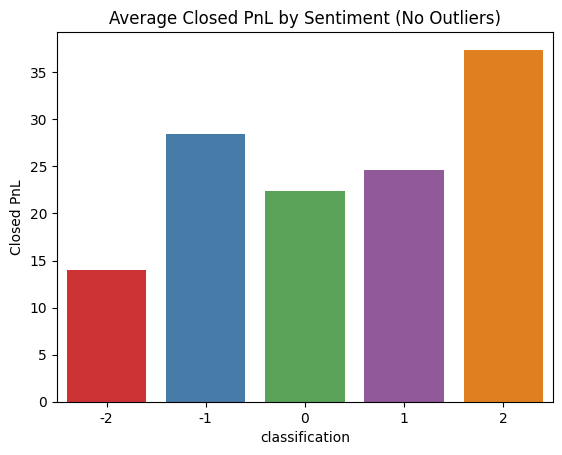

In [11]:
avg_pnl = merged_dataset_no_outliers.groupby("classification")["Closed PnL"].mean().reset_index()
sns.barplot(x="classification", y="Closed PnL", data=avg_pnl, palette="Set1")
plt.title("Average Closed PnL by Sentiment (No Outliers)")
plt.show()

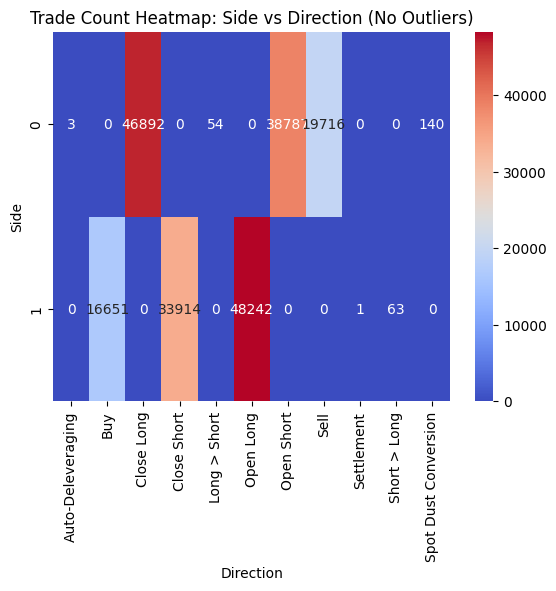

In [12]:

pivot_table = pd.crosstab(merged_dataset_no_outliers["Side"], merged_dataset_no_outliers["Direction"])
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="coolwarm")
plt.title("Trade Count Heatmap: Side vs Direction (No Outliers)")
plt.show()

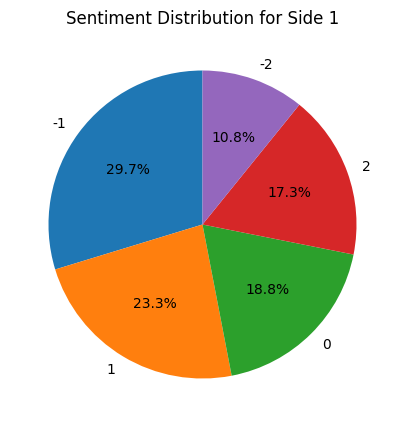

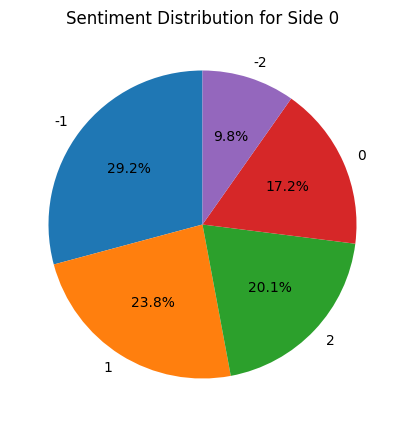

In [13]:
for side in merged_dataset_no_outliers["Side"].unique():
    plt.figure(figsize=(5,5))
    sentiment_counts = merged_dataset_no_outliers[merged_dataset_no_outliers["Side"] == side]["classification"].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"Sentiment Distribution for Side {side}")#0->Sell 1->Buy
    plt.show()

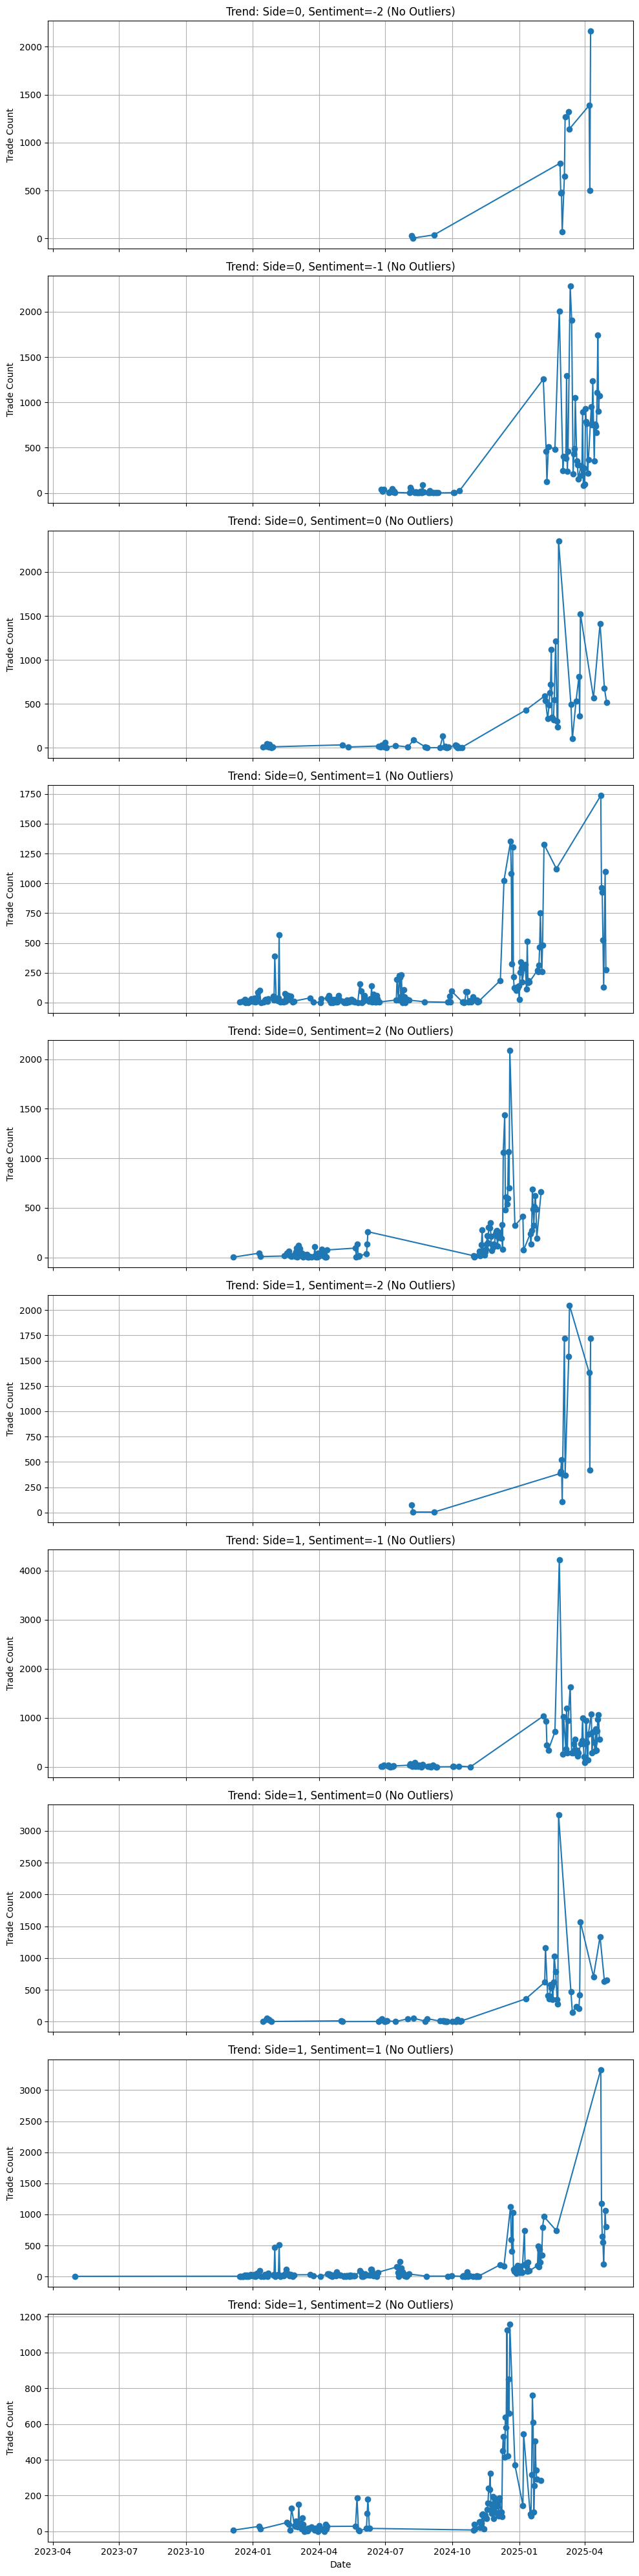

In [14]:
sentiment_trend = merged_dataset_no_outliers.groupby(["date", "Side", "classification"]).size().reset_index(name="count")
combos = list(sentiment_trend.groupby(["Side", "classification"]).groups.keys())

# Create subplots grid
fig, axes = plt.subplots(len(combos), 1, figsize=(10, 4 * len(combos)), sharex=True)

if len(combos) == 1:
    axes = [axes]  # Ensure iterable if only 1 subplot

# Plot each combo on its own subplot
for ax, (side, sentiment) in zip(axes, combos):
    group_data = sentiment_trend[(sentiment_trend["Side"] == side) & (sentiment_trend["classification"] == sentiment)]
    ax.plot(group_data["date"], group_data["count"], marker='o', linestyle='-')
    ax.set_title(f"Trend: Side={side}, Sentiment={sentiment} (No Outliers)")
    ax.set_ylabel("Trade Count")
    ax.grid(True)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


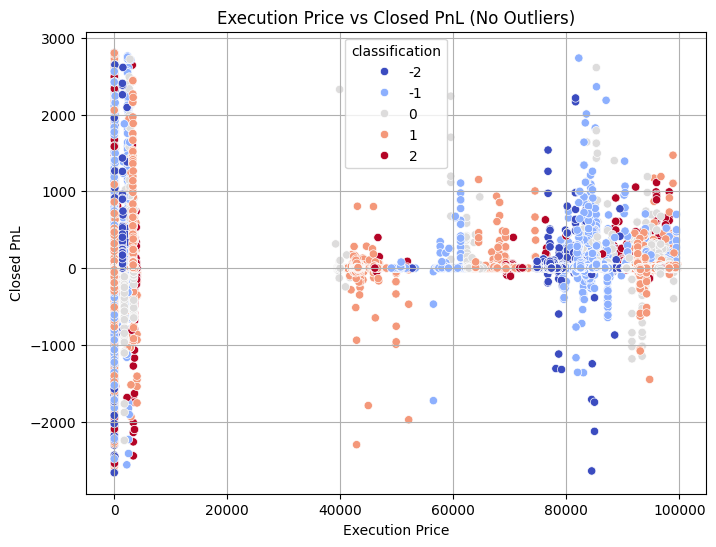

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_dataset_no_outliers,
                x="Execution Price", y="Closed PnL",
                hue="classification", palette="coolwarm")
plt.title("Execution Price vs Closed PnL (No Outliers)")
plt.xlabel("Execution Price")
plt.ylabel("Closed PnL")
plt.grid(True)
plt.show()

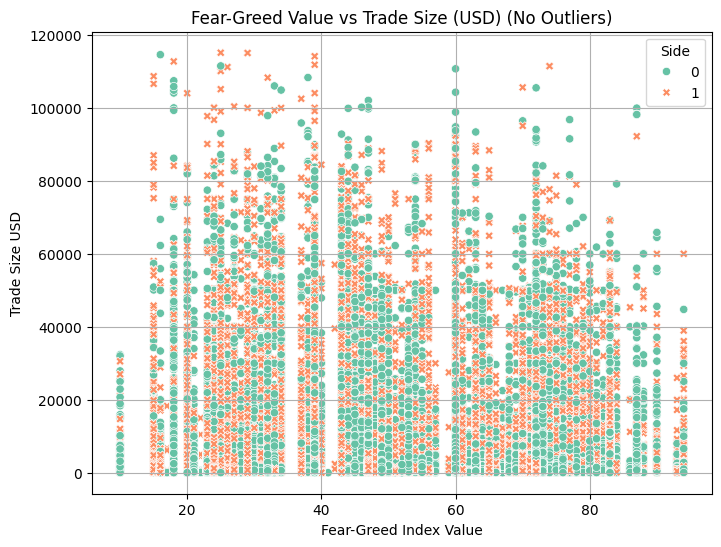

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_dataset_no_outliers,
                x="value", y="Size USD",
                hue="Side", style="Side", palette="Set2")
plt.title("Fear-Greed Value vs Trade Size (USD) (No Outliers)")
plt.xlabel("Fear-Greed Index Value")
plt.ylabel("Trade Size USD")
plt.grid(True)
plt.show()

In [17]:
feature_cols = ["Coin", "Execution Price", "Size Tokens", "Size USD", "Side",
                "Start Position", "Direction", "Closed PnL", "Fee", "value",
                "classification", "price_change", "rolling_mean_3",
                "pnl_per_token", "sentiment_side"]

X = merged_dataset[feature_cols]
y = merged_dataset["market_trend"]



In [18]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le


In [19]:
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

In [20]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

In [27]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
rf= RandomForestClassifier(random_state=42, n_jobs=-1)

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [25]:
y_pred = rf.predict(X_test)

In [26]:
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy: 0.8753

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87     32962
           1       0.86      0.90      0.88     32962

    accuracy                           0.88     65924
   macro avg       0.88      0.88      0.88     65924
weighted avg       0.88      0.88      0.88     65924


Confusion Matrix:
 [[27983  4979]
 [ 3240 29722]]
